In [28]:
import numpy as np
import random
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import trange
from math import e
from scipy.stats import beta
from scipy.spatial import distance
import argparse
import hashlib
import json

def conf2tag(conf, n=8):
    """
    Creates unique tags for tracking experiments.
    """
    return hashlib.sha1(json.dumps(conf, sort_keys=True).encode("utf-8")).digest().hex()[:n]

def generate_optimum(nenvs, neffect):
    """
    Generates optimal expression patterns for different environments.
    Parameters:
        :int nenvs:         Number of different environments that can come up.
        :int neffect:       Number of effector genes, ie genes that matter in fitness function.
    Returns:
        List of optimal expression patterns.
    """
    envs = []
    if nenvs == 2:
        x = np.linspace(0,1,100)
        a, b = 2, 7
        y = beta.pdf(x, a, b) #using probability density function from scipy.stats
        y /= y.max()
        e=[]
        for i in range(neffect):
            t = y[int((100/neffect)*i)]
            t = np.around(t,2)
            e.append(t)
        envs.append(np.asarray(e))
        envs.append(np.asarray(e[::-1]))
    else:
        for env in range(nenvs):
            x = np.linspace(0,1,100)
            a, b = np.random.randint(low=1,high=30,size=1), np.random.randint(low=2,high=30,size=1)
            y = beta.pdf(x, a, b)
            y /= y.max()
            e=[]
            for i in range(neffect):
                t = y[int((100/neffect)*i)]
                t = np.around(t,2)
                e.append(t)
            envs.append(np.asarray(e))
    print("created envs")
    return(envs)


def fitness_function(grn_out,envs,state,args):
    #distance of GRN output to perfect expression in specific environmental state
    if np.sum(grn_out) != 0:
        grn_out = np.asarray(grn_out)

        diff = np.abs(grn_out - envs[state]).sum()
        f = 1-diff/args.E
    else:
        #print('not stable')
        f = 0

    return(f)

def create_pop(args):
    pop = []

    for i in range(args.pop_size):
        t = Agent(i+2, args)
        pop.append(t)

    print("created pop")
    return(pop)

class Agent:
    def __init__(self,ID,args):
        """
        Initialization of an individual.
        Parameters:
            :int ID:        Unique ID of the individual.
        Returns:
            None. Constructor method.
        """

        self.args = args #so that we can run experiments with various parameters

        #BUILDING INITIAL GRN
        N = self.args.E +1
        self.N = N #number of initial nodes, maternal + effectors
        self.nodes = list(np.arange(N))
        self.adjM = np.zeros((N, N))
        self.adjM[0,1:] = 0.1
        #initiate with maternal connected to effector genes
        self.adjM[0,0] = 1
        #and maternal positive feedbackloop (otherwise it turns itself down immediately and so the rest is also repressed)

        #OTHER PARAMETERS
        self.ID = ID
        self.tree = [] #ID and tree for building phylogenic trees
        self.alpha = 10 #for sigmoid function - could be mutated later, now constant
        self.blacklist = [] #set of deleted genes
        self.fitness = 0

        self.dn_rate = self.args.dn_rate
        self.dup_rate = self.args.dup_rate
        self.del_rate = self.args.del_rate
        self.edge_rate = self.args.edge_rate
        #these rates can later be under selection too


    def mutate(self):

        if random.uniform(0, 1) < self.dn_rate:
            self.add_dn_node()

        if random.uniform(0, 1) < self.dup_rate:
            self.add_dup_node()

        if random.uniform(0, 1) < self.del_rate:
            self.del_node()

        if random.uniform(0, 1) < self.edge_rate:
            self.mut_edge()

    def add_dn_node(self):
        #de novo gene, no interactions when initiated
        self.nodes.append(self.N)

        #Make adj matrix bigger
        column_to_be_added = np.zeros(self.N)
        self.adjM = np.column_stack((self.adjM, column_to_be_added))
        self.N += 1

        if self.N > 50:
            print("Number of nodes greater than 50!")

        row_to_be_added = np.zeros(self.N)
        self.adjM = np.vstack((self.adjM, row_to_be_added))

    def add_dup_node(self):
        #duplicate a node with all of its connections
        avail = list(set(self.nodes) - set(self.blacklist) - set(self.args.default_nodes))

        if len(avail) > 0:
            dup_node = np.random.choice(avail)

            column_to_be_added = self.adjM[:,dup_node] #duplicate column
            self.adjM = np.column_stack((self.adjM, column_to_be_added))

            row_to_be_added = self.adjM[dup_node,:] #duplicate row
            self.adjM = np.vstack((self.adjM, row_to_be_added))

            self.nodes.append(self.N)
            self.N += 1

            if self.N > 50:
                print("Number of nodes greater than 50!")

    def del_node(self):
        #delete an existing node with is not an effector or maternal gene
        #rows/columns in adj matrix are not deleted, all interactions are set to 0 instead
        #self.N incudes deleted nodes!
        avail = list(set(self.nodes) - set(self.blacklist) - set(self.args.default_nodes))

        if len(avail) > 0:

            deleted_node = np.random.choice(avail)

            self.adjM[deleted_node,:] = np.zeros(self.N)
            self.adjM[:,deleted_node] = np.zeros(self.N)

            self.blacklist.append(deleted_node)

    def mut_edge(self):
        #mutate the weight of an edge
        avail = list(set(self.nodes) - set(self.blacklist))

        mod_avail_from = list(set(avail) - set(self.args.effectors)) #effectors can't regulate
        from_nodes = np.random.choice(mod_avail_from)

        avail.remove(0) #maternal can't be regulated

        if from_nodes != 0: #otherwise I would remove 0 twice
            avail.remove(from_nodes) #self loops are not allowed

        to_nodes = np.random.choice(avail)

        self.adjM[from_nodes,to_nodes] = np.around(np.random.normal(0, 1, 1), 2)


    def sigm(self,sum_input):
    #adapted from wang 2014
        sum_input = sum_input-0.5
        x = sum_input * -self.alpha
        output = 1/(1 + np.exp(x))
        return output

    def grn_output(self, debug=False):
        a = self.adjM
        if debug:
            print(a)

        step = lambda a,s: self.sigm(s.dot(a)) #a step is matrix multiplication followed by checking on sigmodial function
        s = np.zeros(self.N)
        s[0] = 1 #starts with only maternal factor on
        e=0 #counter for state stability
        i=0 #counter for number of GRN updates
        ss=[] #stores GRN state for comparision to updated state

        while e < 2 and i < 3*(self.N-len(self.blacklist)):
            if debug:
                print(s) #print expression state
            ss.append(s) #only maternal ON at first
            s=step(a,s)
            s=np.around(s,2)
            s[s <=0.01] =0 #otherwise as sigm(0) is 0.01 deleted nodes wouldn't really be deleted
            s[s ==0.99] =1 #otherwise maternat impact is not constant but reducing
            if np.array_equal(ss[i], s):
                if i != 0:
                    e+=1
            i+=1

        if e > 1:
            conc_of_effectors = s[1:self.args.E+1]

        else:
            conc_of_effectors = np.linspace(0,0,self.args.E)
            conc_of_effectors = [int(i) for i in conc_of_effectors]
        return(conc_of_effectors)


def evolve(args):
    #gens = number of generations
    #season_length = number of generations before environment switches
    pop = create_pop(args)
    state = 0 # we start with environment 0
    envs = generate_optimum(args.nenv,args.E)

    average_fitness = [] #for tracking average fitness in pop per generation
    ave_grnsize = [] #average GRN size

    for i in trange(args.gens):
        #every generation
        #check fitness and generate based on that new population

        grn_size=[]

        for idx, ind in enumerate(pop): #mutate and change ID
            ind.mutate()
            if i > 0:
                ind.ID = 2+(args.pop_size*i)+idx
            ind.tree.append(ind.ID)
            grn_size.append(ind.N-len(ind.blacklist))

        ave_grnsize.append(np.average(grn_size))

        for p in pop:
            grn_out = p.grn_output()
            p.fitness = fitness_function(grn_out,envs,state,args) #will depend on env

        pop_fitness = [x.fitness for x in pop]
        tot_fitness = np.sum(pop_fitness)
        average_fitness.append(np.mean(pop_fitness))


        pop_prob = [f/tot_fitness for f in pop_fitness]
        new_pop = np.random.choice(pop, args.pop_size, p=pop_prob, replace = True) #same individual can be selected over and over again
        pop = [deepcopy(agent) for agent in new_pop]


        rd = (i+1) % args.season_length

        if rd == 0:
            #print("after this changed state")
            if state == 0:
                state = 1 #np.random.choice(nenvs)
            else:
                state = 0

    best_agent = max([{"fitness" : x.fitness, "Agent" : x} for x in pop], key=lambda x : x["fitness"])["Agent"]

    return(pop, average_fitness, ave_grnsize)




In [29]:
if __name__ == "__main__":
    # Here the stuff you want to execute with python main.py


    parser = argparse.ArgumentParser(description='Process some integers.')

    parser.add_argument('-E', type=int, default=4, help="Number of effector genes")

    #number of environments that fluctuate, IMPORTANT VARIABLE
    parser.add_argument('-nenv', type=int, default=2, help="Number of environments")

    #arbitrary mutation rates
    #we could also make these rates evolve themselves
    parser.add_argument('-dn_rate', type=float, default=0.005, help="De novo Mutation rate")
    parser.add_argument('-dup_rate', type=float, default=0.005, help="Dup Mutation rate")
    parser.add_argument('-del_rate', type=float, default=0.01, help="Del Mutation rate")
    parser.add_argument('-edge_rate', type=float, default=0.8, help="Edge Mutation rate")

    parser.add_argument('-pop_size', type=int, default=1000, help="Population size")
    parser.add_argument('-gens', type=int, default=1000, help="Number of generations")
    parser.add_argument('-season_length', type=int, default=10000, help="Number of generations in an env")
    parser.add_argument('-exp_type', type=str, default="ANONYMUS", help="Name your experiment for grouping")
    parser.add_argument('-rep', type=str, default="1", help="ID of replicate")

    args = parser.parse_args("")

    tag = conf2tag(vars(args))

    ### Important variables to set

    args.default_nodes = np.linspace(0,args.E,args.E+1)
    args.default_nodes = [int(i) for i in args.default_nodes] #maternal factor and E effector genes, can't be duplicated or removed
    args.effectors = np.delete(args.default_nodes, 0) #effector genes don't have outgoing edges, only incoming
    args.name_of_file = args.exp_type + tag + "_" + args.rep
    print(args.name_of_file)


    ### RUN CODE
    print("running code")
    pop, average_fitness, ave_grnsize = evolve(args)

  0%|          | 0/1000 [00:00<?, ?it/s]

ANONYMUSd89f9011_1
running code
created pop
created envs


100%|██████████| 1000/1000 [14:58<00:00,  1.11it/s]


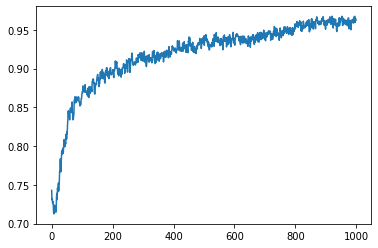

In [30]:
plt.plot(average_fitness)

plt.savefig('ave_fit2.png')

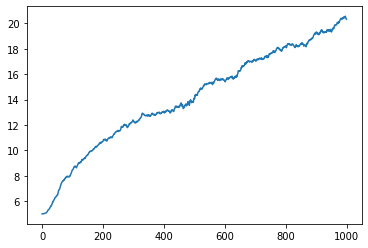

In [31]:
plt.plot(ave_grnsize)
plt.savefig('ave_size.png')